# **Modern Theory of Detection and Estimation**
## **Lab 1. Machine Learning for Regression**
### **Academic Year 2024/2025**

Bachelor's Degree in:
*   Mobile and Space Communications Engineering (groups 61 and 65)
*   Sound and Image Engineering (groups 66 and 69)
*   Telecommunication Technologies Engineering (groups 91, 92, and 95)
*   Telematics Engineering (groups 71 and 79)

Signal Theory and Communications Department.



# **Logistics**


**Setup Instructions**

You will need the files found on Aula Global (in the master group). Please download the files over to your own private folder. Navigate to the folder where you saved the files; it should contain "Lab_regression_student_24_25.ipynb" and "data_lab_reg.csv". Open Google Colab and upload the notebook. Sometimes, it may take a minute or so for a new Jupyter server to start. Once it's ready, you're all set to begin!

In the notebook, you will clearly see where you need to add code for the different problems or write answers to questions

#**Objective**

Breast cancer is a condition many of us have either experienced indirectly or heard about. It is the most common cancer among women, affecting 2.1 million globally each year and causing the highest number of cancer-related deaths in women. According to the World Health Organization (WHO), in 2022 alone, 2.3 million women were diagnosed with breast cancer, resulting in 670 000 deaths worldwide.

Accurately estimating prognosis and survival duration is critical in the clinical decision-making process for cancer patients. Even patients with the same stage and similar clinical characteristics can show varying responses to treatment and survival outcomes. But why?

Cancers are often linked to genetic abnormalities. Gene expression, which measures the activity of genes in a tissue, provides insights into the biological processes within that tissue. By comparing gene expression between normal and cancerous tissues, we can gain a deeper understanding of cancer prognosis and outcomes. Applying **machine learning techniques on genetic data** holds great promise for predicting **survival times** more accurately, potentially helping to avoid unnecessary surgeries and treatments.

In this assignment, we will work with data from the **Molecular Taxonomy of Breast Cancer International Consortium (METABRIC)**, a Canada-UK initiative containing genetic sequencing data from 1980 primary breast cancer samples. Our **goal will be to estimate tumor size** using this data. The clinical and genomic information is sourced from cBioPortal, a web-based platform for exploring multidimensional cancer genomics data. For more details, feel free to explore [cBioPortal](https://www.cbioportal.org/)) on your own.

**LET'S GET STARTED!**



Let's prepare our environment by installing the necessary libraries, and then we can import the data!


In [ ]:
#Import the Python libraries that will be used in this lab assignment
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

#To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

# 1.&nbsp;Breast cancer dataset


## 1.1 Description

In this lab, we will use the Brain Cancer dataset, which includes information about cancer patients, such as genomic expressions, age, and other clinical characteristics. The objective is to predict tumor size (column `tumor_size`) by analyzing the available data.

This dataset is a simplified version of the original dataset from [Kaggle](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric) and contains a curated subset of the most relevant features for our analysis.


### Getting the data

Let's begin by uploading the dataset from your local machine. In the code cell below, click on "Choose Files" (or "Elegir archivos", if your interface is in Spanish), and select the file named "data_lab_reg.csv" to upload.

Wait until the upload is fully completed (you should see a "100% done" status).

**Note**: Once the file is successfully uploaded to Google Colab, you’ll see its name appear in the interface.


In [ ]:
#Importing the dataset
from google.colab import files

uploaded = files.upload()

In [ ]:
#Reading the csv file into a DataFrame called Data
Data = pd.read_csv('data_lab_reg.csv', index_col=0)

# Getting the column names!
feature_names = Data.columns.values[1:]

The data is now loaded into a DataFrame named `Data`. Let's take a look at the information it contains!

In [ ]:
#Displaying all columns and rows of the DataFrame
display(Data)

As can be observed, there are 1904 samples (or observations), each corresponding to 495 variables (or features). The **corresponding target** is the **tumor size** (in the `tumor_size` column).

The variables that form each observation are:

* `tumor_size` (`float`):	Tumor size measured by imaging techniques.
* `age_at_diagnosis` (`float`): Age of the patient at diagnosis time.
* `lymph_nodes_examined_positive` (`float`): Number of lymph node during the surgery that were involved in cancer.
* `mutation_count` (`float`):	Number of gene that has relevant mutations
* `nottingham_prognostic_index` (`float`): It is used to determine prognosis following surgery for breast cancer. Its value is calculated using three pathological criteria: the size of the tumour; the number of involved lymph nodes; and the grade of the tumour.
* `overall_survival_months` (`float`):	Duration from the time of the intervention to death

The genetics part of the dataset contains m-RNA levels z-score for 331 genes, and mutation for 175 genes.
Textual and categorical variables have been removed, leaving 495 available features.

It is easy to observe that all the aforementioned **features** are **numerical values**!



In [ ]:
#To show the type of each feature
Data.dtypes

Below is the **statistical summary** of the **numerical features**.

In [ ]:
Data.describe().T

Although you will find the answer later on, do you think it is appropriate for the `count` variable to have different values depending on the feature being analyzed? Take a moment to quickly review the `mutation_count`, `tumor_size`, and the other variables.


Let's take a closer look at the `mutation_count`variable.



In [ ]:
Data['mutation_count']

With `pandas`, a null value is considered missing and is denoted by NaN (Not a Number). As can be observed, the `mutation_count` variable contains some NaN values.

Machine learning models require numerical input without missing values, so we must handle these missing values before proceeding.

There are several strategies for dealing with missing data:

1. **Removing samples** with missing values can work if there are enough samples remaining and the number of missing samples is small.
2. **Removing features** with missing values is a good option when the feature isn't critical to the problem.
3. **Imputing missing values**. When features are informative and removing samples is not an option, we can attempt to estimate what the missing values should be.

Let's analyze how many samples have missing values and identify which features are affected.

In [ ]:
#Computing the number of rows with NaN and identifying the features!
num_rows_with_nans = Data.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {num_rows_with_nans}")
cols_with_nans = Data.columns[Data.isnull().any()]
print("\nColumns with missing values: ")
print(cols_with_nans)
for col in cols_with_nans:
    print(f"- {col}")

There are only two features with missing values, one of which is the target variable in this lab assignment. Out of 1,905 samples, only 65 have missing values. We'll proceed by removing these samples, following the first approach (removing samples with missing data).

In [ ]:
#To drop the rows where at least one element is missing.
Data = Data.dropna()
display(Data)

The **DataFrame** you should obtain **must have 1839 rows and 495 columns**. If you do not get these dimensions, review your code or ask the professor before proceeding!

## 1.2 Data preparation

### 1.2.1 Preparing the data ($X$) and the target ($y$)

Create the matrix for the data ($X$) and the target vector ($y$). $X$ represents the observed data, while $y$ is a vector containing the desired values (also known as "targets" or "labels") that we aim to predict. In this assignment, the targets are the values in the  `tumor_size` column. Therefore, $y$ is a one-dimensional array whose length corresponds to the number of samples.




The dimensions of $X$ are $1839\times494$, where the number of rows corresponds to the number of observations, and the number of columns represents the features.

In [ ]:
# Let's obtain the data (X) and the targets (y)
X = Data.loc[:,Data.columns[1:]].values
y = Data.loc[:,Data.columns[0]].values

Let's verify that everything is correct. How many samples are there in the dataset? Print the result!

In [ ]:
#YOUR CODE HERE
# n_samples = ...
# print(...

What is the number of features per sample? Print the result!

In [ ]:
#YOUR CODE HERE
# n_features = ...
# print(...

### 1.2.2 Training, validation and test sets

Splitting the dataset $([X,y])$ is crucial for an unbiased evaluation of prediction performance. Typically, the data is split into three subsets:


*   The **training set** is used to train, or **fit**, the model. For example, it can be applied to determine the optimal weights (or coefficients) for linear regression, among other models.



*  The **validation set** is used for unbiased model evaluation during hyperparameter tuning. For example, when tuning (finding the optimal value of) the `alpha` parameter in a Ridge regressor or selecting the best `kernel` for Kernel Ridge regression, you experiment with different values or types of kernels. For each chosen set of hyperparameters, the model is trained using the training set and its performance is evaluated on the validation set.


*   The **test set** is required for an unbiased evaluation of the final model. It should not be used for training or validation purposes.

The sklearn function [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) can handle this task for you!

**Note:** When comparing machine learning algorithms,  it is important to fit and evaluate them on the same subsets of the dataset. This can be achieved by fixing the seed for the pseudo-random number generator used when splitting the dataset. In the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function, this can be done by setting the `random_state` parameter to a specific integer value.



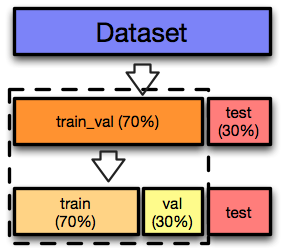

Splitting your **data** into **training_val** and **testing** subsets (70/30) is indeed a good starting point!

For simplicity, use the names `X_train_val`, `X_test`, `y_train_val`, and `y_test` for the corresponding NumPy arrays.


$\underline{\text{Note}}$: Set the `random_state` to a fixed value,  such as 42.

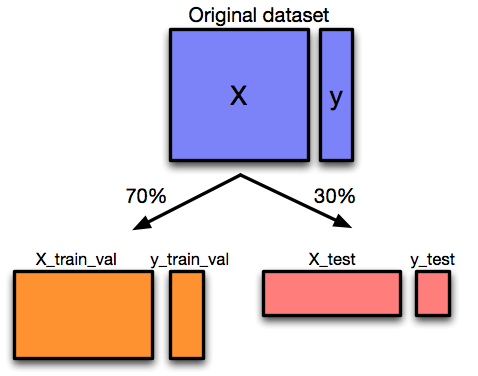

In [ ]:
from sklearn.model_selection import train_test_split
#YOUR CODE HERE
# Initialize the variables X_train_val, X_test, y_train_val and y_test


How many samples are there in both subsets? Print the result!

In [ ]:
#YOUR CODE HERE
# n_tr_val  = ...
# n_tst     = ...
# print(...


Now, split your **training_val data** ([`X_train_val`, `y_train_val`]) into two subsets: **train** and **val** (70/30).
For simplicity, use the names `X_train`, `X_val`, `y_train`, and `y_val` for the corresponding Numpy arrays.



$\underline{\text{Note}}$: Again, set the `random_state` to a fixed value, such as 42.

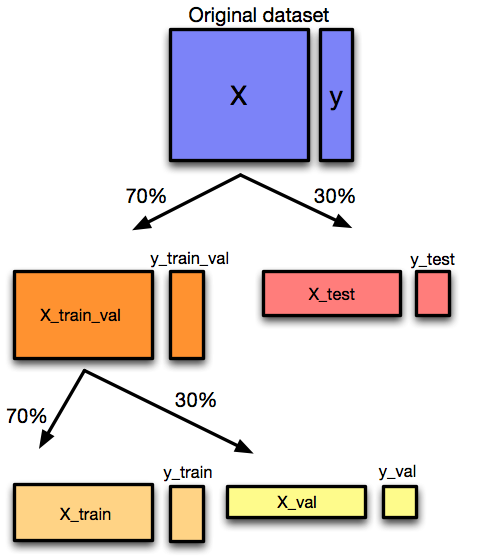

In [ ]:
#YOUR CODE HERE
# Initialize the variables X_train, X_val, y_train and y_val

How many samples are there in the training, validation, and test subsets, respectively?

In [ ]:
#YOUR CODE HERE
# n_tr  = ...
# n_val = ...
# n_tst = ...
# print(...

Please, check that the total number of samples is 1839!

In [ ]:
#YOUR CODE HERE
# n_tot = ...
# print(...

At this moment, there are $3$ subsets avaible for implementing the regression models:
*   `[X_train, y_train]`
*   `[X_val, y_val]`
*   `[X_test, y_test]`

# <font color = 'black'> 2. Modeling </font>

## 2.1 Regression evaluation metrics

Here are two common evaluation metrics for regression problems:

1)   The **coefficiente $R^2$** indicates the proportion of the variance in the estimated variable ($\widehat{y}$) that can be explained by the observed variables. It can be computed as follows:

$$
R^2 = 1-\frac{\sum\limits_{i=1}^{N_t}{(y_i-\hat{y}_i)^2}}{\sum\limits_{i=1}^{N_t}{(y_i-\bar{y})^2}}
$$where:

* $N_t$ represents the number of samples in the set.
* $\hat{y}_i$, $\,\,i=1,\dots,N_t\,$ represents the estimated values (or predictions) made by the regressor for each $i$-th sample in the set.
* $y_i$, $\,\,i=1,\dots,N_t\,$ denotes the correct target values for each $i$-th sample in the set.
*$\bar{y}=\frac{1}{N_t}\sum\limits_{i=1}^{N_t}y_i\,$ is the average of the true target values for the samples in the set.

$R^2$ reaches a maximum value of $1$ when the model makes exact predictions for all the target values. The value of $R^2$ decreases as the prediction errors increase.

If the model is not perfect but still performs better than a trivial model, then $0 < R^2 < 1$. If $R^2$ drops below $0$ and takes negative values, it indicates that the model's predictions are worse than simply using the mean of the true labels from the dataset used to design the regressor (a trivial estimation).

In Python, there are several ways to calculate this coefficient:

  *   Using the `r2_score` function  from the `sklearn.metrics` module.
  *   Using the `score()` method available in each regression model.


2)  The **Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:


$$\text{RMSE} = \sqrt{\frac {1}{N_t}\sum_{i=1}^{N_t}\Big(y_i-\hat{y}_i\Big)^2}$$

The lower the RMSE, the better the model fits the data.

In Python, this error can be calculated by using the `mean_squared_error` function  from the `sklearn.metrics` module, with the parameter `squared` set to `False`.




## 2.2 Standardization of features
The variables in a dataset can vary significantly in scale, so a common pre-processing step is to normalize them to ensure comparability.

One of the most widely used methods is **standardization**, which transforms each variable to have a mean of zero and a standard deviation of one. This is done by subtracting the mean and dividing by the standard deviation for each variable.


The [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) model from `Scikit-learn` can handle this task for you!


For this purpose, perform the following steps:
*  Create an instance of `StandardScaler`.
*  Fit the scaler using the training data (`X_train`).
*  Create three new matrices:
    - `X_train_s`: It contains the result of transforming `X_train` with the scaler.
    - `X_val_s`: It contains the result of transforming `X_val` with the scaler.
    - `X_test_s`: It contains the result of transforming `X_test` with the scaler.



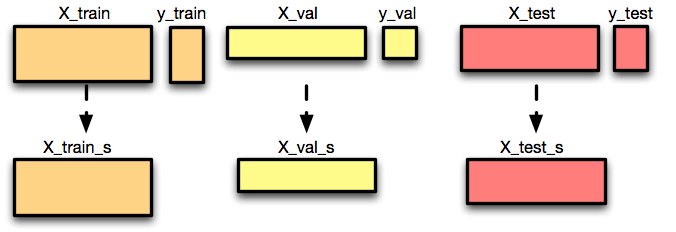

In [ ]:
from sklearn.preprocessing import StandardScaler
#YOUR CODE HERE
# ...
# ...
# X_train_s = ...
# X_val_s = ...
# X_test_s = ...

In [ ]:
#Let's check out that everything is ok!
train_means = np.round(np.mean(X_train_s, axis=0),2)
train_stds = np.round(np.std(X_train_s, axis=0),2)

val_means = np.round(np.mean(X_val_s, axis=0),2)
val_stds = np.round(np.std(X_val_s, axis=0),2)

test_means = np.round(np.mean(X_test_s, axis=0),2)
test_stds = np.round(np.std(X_test_s, axis=0),2)

data = {'Train Mean': train_means, 'Train Std': train_stds,
        'Validation Mean': val_means, 'Validation Std': val_stds,
        'Test Mean': test_means, 'Test Std': test_stds}

df_stats = pd.DataFrame(data, index = feature_names)
df_stats

From now on, please work with **standardized features**. In other words, the three subsets for implementing the regression models are:
*   `[X_train_s, y_train]`
*   `[X_val_s, y_val]`
*   `[X_test_s, y_test]`



## 2.3 Designing the estimation models

### 2.3.1 Linear regression

In this section, we will implement a **linear regression model**. This model assumes that there is a linear relationship between the independent variables (input features) and the dependent variable (output).

> **Training the model**

*   First, import the class: `from sklearn.linear_model import LinearRegression`
*   Then, instantiate the model object.
*   Next, fit the training data. This creates a trained regression model (an object of the `LinearRegression` class).

The variety of methods and attributes available for the regression model can be explored [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [ ]:
from sklearn.linear_model import LinearRegression
#YOUR CODE HERE
# lr = ...

> **Prediction from our model**

Let's generate predictions from our test set and evaluate how well the model performed!

In [ ]:
#YOUR CODE HERE
# y_pred_lr = ...

> **Evaluation the model**

Let's evaluate the model by computing the $R^2$ and RMSE metrics, and then print the results. Please round all numbers to 2 decimal places.

In [ ]:
#YOUR CODE HERE
# ...
# r2_lr= ...
# rmse_lr = ...

print('RMSE for linear regression model is:',rmse_lr)
print('R2 for linear regression model is:',r2_lr)

In [ ]:
# Produce a scatter plot with the representation of the real value of the label vs. the estimated value obtained for the training set.
s_train_lr = lr.predict(X_train_s)
plt.scatter(y_train,s_train_lr)
p1 = max(max(s_train_lr), max(y_train))
p2 = min(min(s_train_lr), min(y_train))
plt.plot([p1, p2], [p1, p2], 'r-')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

Having a look at the scatter plot and keeping in mind the R2 performance of the regressor, what do you think is happening?


<font color = 'green'> YOUR ANSWER HERE


###2.3.2 Linear ridge regression

In this section, we will implement a **linear ridge regression model**. This model also assumes a linear relationship between the independent variables (input features) and the dependent variable (output). However, Ridge Regression introduces a regularization term to the linear regression (hyperparameter `alpha`), which helps preventing overfitting by penalizing large coefficients in the model.

> **Selecting the best value of `alpha`**

The first task is to find an *optimal* value for `alpha` (a hyperparameter in the linear ridge regression model that controls the strength of regularization). In this assignment, the range of `alpha` values to explore is `[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 50000, 100000]`. For each value of `alpha`, compute the $R^2$ score for the validation set and plot all the metrics on the same figure.

To achieve this, follow these steps:

*   First, import the class: `from sklearn.linear_model import Ridge`
*   Then, create the model object.
*   Next, fit the training data. This creates a trained model (an object) of the Ridge regression class.
*   Next, fit the training data. This creates a trained model (an object) of the Ridge regression class.
After that, compute the $R^2$ for the validation data, store it in a 1D array, and plot it in a figure. Please use a log scale on the x-axis.




In [ ]:
from sklearn.linear_model import Ridge

# YOUR CODE HERE



What is the best value for `alpha`? Why?


<font color = 'green'> YOUR ANSWER HERE

In [ ]:
# YOUR CODE HERE
# ...
# ...

#alpha_best = ...

print('The best value of alpha is: ',alpha_best )

> **Training and evaluating the model**

*   Now, create a model object from the Ridge class.
*   Next, fit the training data using the *optimal* value of `alpha`.
*   Let's evaluate the model by computing the $R^2$ and RMSE metrics on the test set, and print out the results. Please round all numbers to 2 decimal places.




In [ ]:
# YOUR CODE HERE
# ...



print('RMSE for Ridge regression model is:',rmse_ridge)
print('R2 for Ridge regression model is:',r2_ridge)

In [ ]:
# Produce a scatter plot with the representation of the real value of the label vs the estimated value with the best value of alpha for the training set.
s_ridge = ridge_best.predict(X_train_s)
plt.scatter(y_train,s_ridge)
p1 = max(max(s_ridge), max(y_train))
p2 = min(min(s_ridge), min(y_train))
plt.plot([p1, p2], [p1, p2], 'r-')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

Do you observe any difference with the previous figure? Why is it happening?


<font color = 'green'> YOUR ANSWER HERE

###2.3.3 Linear lasso regression

In this section, we will implement a **linear lasso regression model**. Like ridge regression, this model assumes a linear relationship between the independent variables (input features) and the dependent variable (output). However, lasso legression introduces a regularization term controlled by the hyperparameter `alpha`, which helps prevent overfitting by penalizing the absolute values of the model coefficients. Additionally, lasso can drive some coefficients to zero, effectively performing feature selection by excluding less important variables from the model.


> **Selecting the best value of alpha**

As previously, the first task is to obtain an *optimal* value of `alpha` for the lasso regressor.

In this assignment, the corresponding range that will be explored for `alpha` is: `[0.001, 0.01, 0.05, 0.1, 1, 5, 10]`. For each value of `alpha`, compute the $R^2$ score for the validation set and plot all the metrics on the same figure.

To achieve this, follow these steps:

*   First, import the class: `from sklearn.linear_model import Lasso`
*   Then, create the model object.
*   Next, fit the training data. This creates a trained model (an object) of the lasso regression class.
*   Finally, compute the $R^2$ for the validation data, store it in a 1D array, and plot it in a figure. Please use a log scale on the x-axis.





In [ ]:
# YOUR CODE HERE
# ...

What is the best value for `alpha`? Why?

<font color = 'green'> YOUR ANSWER HERE

In [ ]:
# YOUR CODE HERE
# ...
# ...
#alpha_best = ...

print('The best value of alpha is: ',alpha_best )

> **Training and evaluating the model**

*   Now, create a model object from the lasso class.
*   Next, fit the training data using the *optimal* value of `alpha`.
*   Let's evaluate the model by computing the $R^2$ and RMSE metrics on the test set, and print out the results. Please round all numbers to 2 decimal places.

In [ ]:
# YOUR CODE HERE
# ...
# ...
#r2_lasso = ...
#rmse_lasso = ...

print('RMSE for Lasso regression model is:',rmse_lasso)
print('R2 for Lasso regression model is:',r2_lasso)

In [ ]:
# Produce a scatter plot with the representation of the real value of the label vs the estimated value with the best value of alpha for the training set.
s_lasso = lasso_best.predict(X_train_s)
plt.scatter(y_train,s_lasso)
p1 = max(max(s_lasso), max(y_train))
p2 = min(min(s_lasso), min(y_train))
plt.plot([p1, p2], [p1, p2], 'r-')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

Having a look at the metrics reached by the three regression models explored (linear regression, Ridge regression and Lasso regression) which technique seems to be most adequate for this task? What does it do that the rest don't? Justify your answer

<font color = 'green'> YOUR ANSWER HERE

### 2.3.4 Kernel Ridge Regression

In this section, we will implement a **kernel ridge regression model**. Like ridge regression, this model assumes a relationship between the independent variables (input features) and the dependent variable (output). However, kernel ridge regression extends ridge regression by incorporating the use of kernels, which lets the model represent non-linear relationships in the data. The model includes a regularization term controlled by the hyperparameter alpha, which helps prevent overfitting by penalizing the magnitude of the model coefficients. By using kernels, this method can project the input data into higher-dimensional spaces, enabling it to handle more complex patterns.

Although the kernel is a hyperparameter that can be tuned, in this assignment, it has been chosen the `rbf` kernel. RBF (Radial Basis Function) kernels are among the most extended forms of kernelization and are widely used due to their similarity to the Gaussian distribution, making them a versatile choice for a variety of problems.

> **Selecting the best values of alpha and gamma**

The first task is to obtain an *optimal* value of both `alpha` and `gamma` for the kernel ridge regressor. The hyperparameter `gamma` plays a crucial role. It controls the shape of the kernel and how far the influence of a single training example reaches.  A small `gamma` value results in a smoother, more generalized model where each data point has a broader influence. Conversely, a large `gamma` value leads to a narrower, more localized kernel, where each data point influences the model over a shorter distance.

In this assignment the corresponding ranges that will be explored for `alpha` is: `[0.0001, 0.001, 0.01, 0.1, 1, 10]` and for `gamma`: `[0.0001, 0.001, 0.01, 0.1, 1, 10]`. For each combination of `alpha` and `gamma`, compute the $R^2$ for the validation set.

To achieve this, follow these steps:

*   First, import the class: from `sklearn.kernel_ridge import KernelRidge`
*   Then, create the model object.
*   Next, fit the training data. This creates a trained model (an object) of the kernel ridge regression class.
*   Finally, compute the $R^2$ for the validation data and store it in a 2D array,





In [ ]:
# YOUR CODE HERE
# ...
# ...
# ...

What is the best value for `gamma`? And for `alpha`?

<font color = 'green'> YOUR ANSWER HERE

In [ ]:
# YOUR CODE HERE
# ...
# ...

#alpha_best = ...
#gamma_best = ...

print('The best value of alpha is: ', alpha_best)
print('The best value of gamma is: ', gamma_best)


> **Training and evaluating the model**

*   Now, create a model object from the kernel ridge regression class.
*   Next, fit the training data using the *optimal* values  of `alpha` and `gamma`.
*   Let's evaluate the model by computing the $R^2$ and RMSE metrics on the test set, and print out the results. Please round all numbers to 2 decimal places.

In [ ]:
# YOUR CODE HERE
# ...
# ...

#r2_kernel = ...
#rmse_kernel = ...

print('RMSE for Kernel Ridge regression model is:',rmse_kernel)
print('R2 for Kernel Ridge regression model is:',r2_kernel)

In [ ]:
# Produce a scatter plot with the representation of the real value of the label vs the estimated value with the best values of alpha and gamma for the training set
s_train_kernel_ridge = kernel_ridge.predict(X_train_s)
plt.scatter(y_train,s_train_kernel_ridge)
p1 = max(max(s_train_kernel_ridge), max(y_train))
p2 = min(min(s_train_kernel_ridge), min(y_train))
plt.plot([p1, p2], [p1, p2], 'r-')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

Is there any difference between this representation and those obtained from the other regressors that were previously explored in this assignment?

<font color = 'green'> YOUR ANSWER HERE

# <font color = 'black'> 3. Role of each variable in the model </font>

As explained in the course, the coefficients represent the strength and direction of the relationship between the features and the target variable. If a coefficient is set to $0$, it means that the corresponding feature has been excluded from the model. If the absolute value of a coefficient is close to zero, it indicates that the feature is less significant, whereas a much larger absolute value suggests a stronger influence on the target variable.

## 3.1. Linear regression case
In the linear regression model:
$$
f(\mathbf x) = \mathbf w^\top \mathbf x + w_0 = w_0 + \sum_{k=1}^d w_kx_k
$$

each feature $x_k$ contributes to the predictive function by its value being multiplied by the corresponding weight $w_k$.

Retrieve the coefficients from the  linear regressor in Section 2.3.1 and print the relevance of the features based on these weights.



In [ ]:
#YOUR CODE HERE
# ...
# ...


What is the most relevante feature? And the least one?



<font color = 'green'> YOUR ANSWER HERE

$\underline{\text{Hint}}$: To identify the most and least relevant features in your model, you need to examine the absolute values of the coefficients from the linear regressor. The feature with the highest absolute value coefficient is the most relevant. Conversely, the feature with the smallest absolute value coefficient is the least relevant, meaning it has the weakest impact on the model.


## 3.2 Regression models with the best feature

### 3.2.1 Linear regression

Based on the previous results, **select the most relevant feature** and train a linear regression model using only these features. Then, evaluate the model by computing the $R^2$ and RMSE metrics on the test set, and print the results. Please round all numbers to 2 decimal places.


In [ ]:
#YOUR CODE HERE
# ...
# ...

# X_train_reduced = ...
# X_test_reduced = ...

In [ ]:
#YOUR CODE HERE
# ...
# ...

In [ ]:
#YOUR CODE HERE
# ...
# ...

# r2_lr_best = ...
# rmse_lr_best = ...

print('RMSE for linear regression model (with 1 feature) is:',rmse_lr_best)
print('R2 for linear regression model (with 1 feature) is:',r2_lr_best)

### 3.2.2 Semi-linear regression with the best feature

When using a **semi-linear regression model** that incorporates a quadratic function, you are essentially extending a basic linear regression model to account for non-linear relationships between the features and the output. This approach is called polynomial regression when you introduce quadratic (or higher-order) terms into the model.


Let's see what happens if we use a semi-linear regression model with a quadratic function.

$$
f(x)= w_0 + w_1 x + w_2 x^2
$$

where $x$ represents the observed variable ($-$ best feature in this assignment).


Train and evaluate the model by computing the $R^2$ and RMSE metrics on the test set, and print the results. Please round all numbers to 2 decimal places.

In [ ]:
#YOUR CODE HERE
# ...
# ...

# rmse_lr_sem = ...
# r2_lr_sem = ...

print('RMSE for semilinear-regression model is:',rmse_lr_sem)
print('R2 for semilinear-regression model is:',r2_lr_sem)


Does this improve the results? Why?

<font color = 'green'> YOUR ANSWER HERE



## <font color = 'black'> 3.3 Coefficients of lasso regression </font>

### 3.3.1 Non-zero coefficients

In linear regression with $\ell_1$ regularization (Lasso regression), the regularization term introduces a penalty on the sum of the absolute values of the coefficients, controlled by the hyperparameter `alpha`. This penalty encourages sparsity by driving some coefficients to zero, while the remaining coefficients are constrained to be smaller than a certain value $c$, influenced by the strength of the hyperparameter alpha.

$$
f(\mathbf x) = \mathbf w^\top \mathbf x + w_0 = w_0 + \sum_{k=1}^d w_kx_k \quad s.t. |w| \leq c$$


As mentioned, the key property of $\ell_1$ regularization, lasso, is that it encourages sparsity in the weights $\mathbf{w}$. This means that for many irrelevant or redundant features, the corresponding coefficiente ($w_k$) will be exactly zero. Consequently, these features are effectively excluded from the model.


This ability to select only relevant features is valuable for simplifying the model, improving interpretability, and reducing the risk of overfitting, particularly when dealing with high-dimensional data.

By setting irrelevant features to zero, we can evaluate the model's performance based solely on the most significant features, providing a clearer understanding of how the model makes predictions.

Retrieve the coefficients of the lasso linear regressor from Section 2.3.3. Print which features have non-zero values. Then, create a new variable that stores the training and test matrices with only the features that have non-zero weights.

In [ ]:
#YOUR CODE HERE
# ...
# ...


How many features have non-zero coefficients?



<font color = 'green'> YOUR ANSWER HERE

### 3.3.2 Polynomial feature extension for non-zero coefficient features

Once the features with non-zero coefficients have been identified, extend the selected features from the train and test subsets by taking products of some original columns to construct polynomial functions of the original features.



In `scikit-learn`, there is a module called [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) that allows you to create polynomial expansions of the columns up to a specified degree. In this assignment, the hyperparameter `degree` is set to $2$.


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

#YOUR CODE HERE
# ...
# ...

# Xp_train = ...
# Xp_test = ...

How many features are there in the training and test sets, respectively?

In [ ]:
#YOUR CODE HERE
#n_poly_tr   = ...
#n_poly_tst  = ...

print('The number of training samples is:', n_poly_tr)
print('The number of validation samples is:', n_poly_tst)

**Are all of them important for the regression task?** To answer this question, please use a lasso regressor to determine the regression model in the new feature space created by the polynomial expansion of the columns. For this task, the hyperparameter `alpha` is set to $0.5$.

In [ ]:
#YOUR CODE HERE
# ...
# ...

Is there any coefficient equal to zero?

<font color = 'green'> YOUR ANSWER HERE

In [ ]:
#YOUR CODE HERE
# ...

#coef_zero = ...

print('The number of coefficients equal to zero is: ', coef_zero.shape[1])

Why do you think so many coefficients are zero?

<font color = 'green'> YOUR ANSWER HERE

Calculate the $R^2$ and RMSE metrics on the *new *test set and print the results. Please round all numbers to 2 decimal places.

In [ ]:
#YOUR CODE HERE
# ...

# rmse_lasso_poly = ...
# r2_lasso_poly = ...

print('RMSE for polynomial Lasso model is:',rmse_lasso_poly)
print('R2 for polynomial Lasso model is:',r2_lasso_poly)

# <font color = 'black'> 4. Best regression model </font>

It has always been said that we understand faster when we visualize data. In this final section of the assignment, we will determine which regression model is the best fit for our data!

Using a bar plot, represent the $R^2$ obtained by each regression model evaluated in this assignment (trained with its best hyperparameters) for the **test set**. Also, include the values obtained in Section 3.





In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

In [ ]:
#YOUR CODE HERE
# ...
# ...
# ...

Which model achieves the best $R^2$ score?

<font color = 'green'> YOUR ANSWER HERE

### **This was your first real machine learning project! Congratulations!**
### **We'll let this end here for now!**
